<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

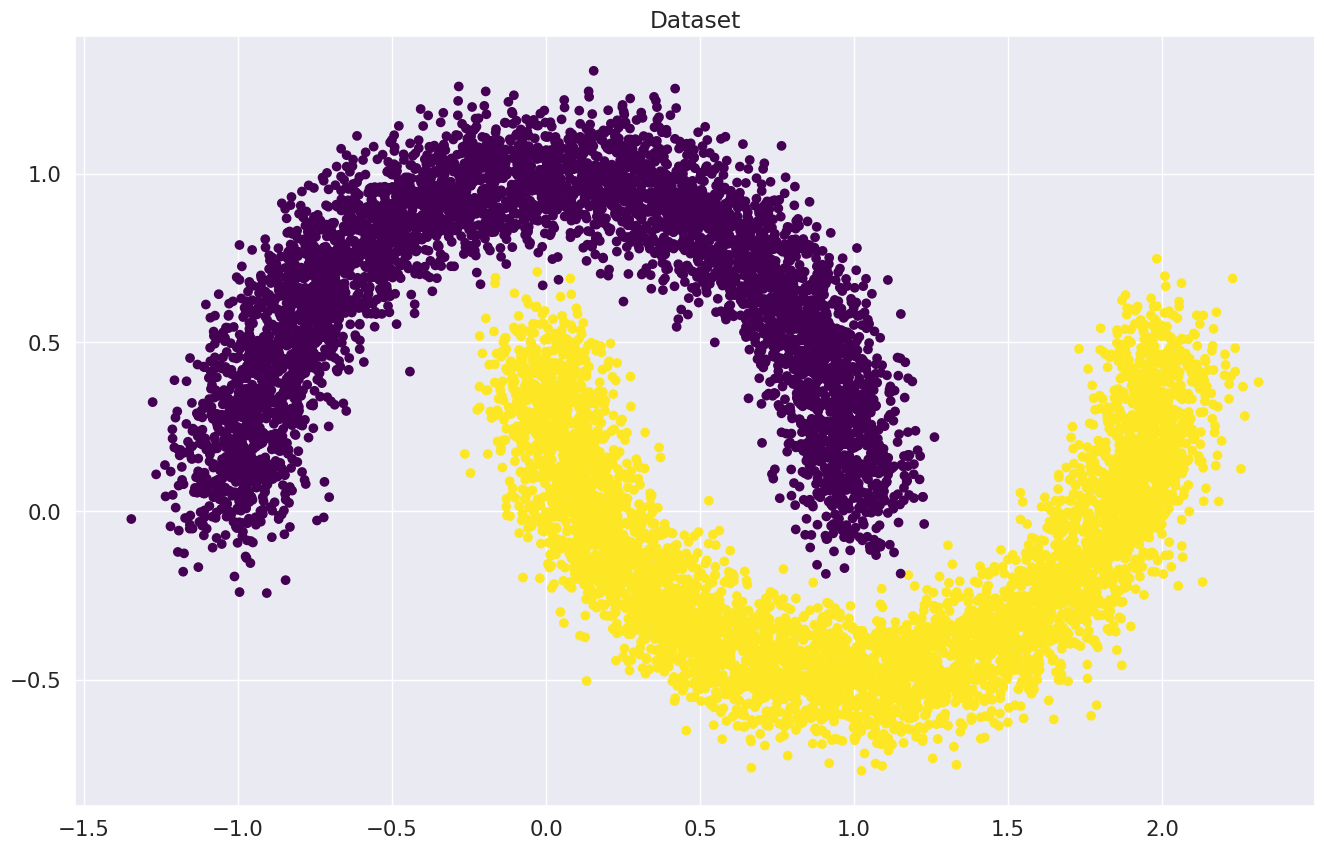

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.int64)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.int64)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
# Определение модели
linear_regression = LinearRegression(2, 1)

# Подсчет количества обучаемых параметров
num_params = sum(p.numel() for p in linear_regression.parameters())
print(f"Количество обучаемых параметров: {num_params}")


Количество обучаемых параметров: 3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.int64)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp = linear_regression(X_batch)
        loss = loss_function(outp.flatten(), y_batch.float())
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.8359375

Iteration: 1.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

*   Чтобы узнать, сколько итераций потребовалось для сходимости, необходимо отследить, на какой итерации цикл обучения прерывается из-за выполнения условия сходимости. Это происходит, когда разница между текущими и предыдущими весами становится меньше заданного порога tol.



**Ответ:** 18. См код ниже.

In [ ]:
tol = 1e-3  # Порог для остановки
losses = []  # Список для хранения значений функции потерь
max_epochs = 100  # Максимальное количество эпох
prev_weights = torch.zeros_like(linear_regression.weights)  # Инициализация прошлых весов
stop_it = False  # Флаг для досрочной остановки

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        # Шаг 1: Обнуление градиентов
        optimizer.zero_grad()

        # Шаг 2: Получение выходов модели
        outp = linear_regression(X_batch)

        # Шаг 3: Вычисление функции потерь
        loss = loss_function(outp.flatten(), y_batch.float())  # Преобразование меток в float

        # Шаг 4: Обратное распространение ошибки
        loss.backward()

        # Шаг 5: Шаг оптимизации
        optimizer.step()

        # Сохранение значения функции потерь
        losses.append(loss.detach().item())

        # Шаг 6: Вычисление вероятностей
        probabilities = torch.sigmoid(outp)  # Функция активации сигмоида для вывода логитов

        # Шаг 7: Прогнозы и точность на батче
        preds = (probabilities > 0.5).type(torch.long)  # Классификация (порог 0.5)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).mean()  # Средняя точность на батче

        # Вывод промежуточной информации каждые 100 итераций
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc.item()}")

        # Шаг 8: Проверка условия сходимости (проверка изменений весов)
        current_weights = linear_regression.weights.detach().clone()  # Копия текущих весов
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}. Convergence. Stopping iterations.")
            stop_it = True
            break

        prev_weights = current_weights  # Обновление прошлых весов для следующей итерации

    if stop_it:
        break


Iteration: 0
Batch accuracy: 0.84375

Iteration: 23. Convergence. Stopping iterations.


### Визуализируем результаты

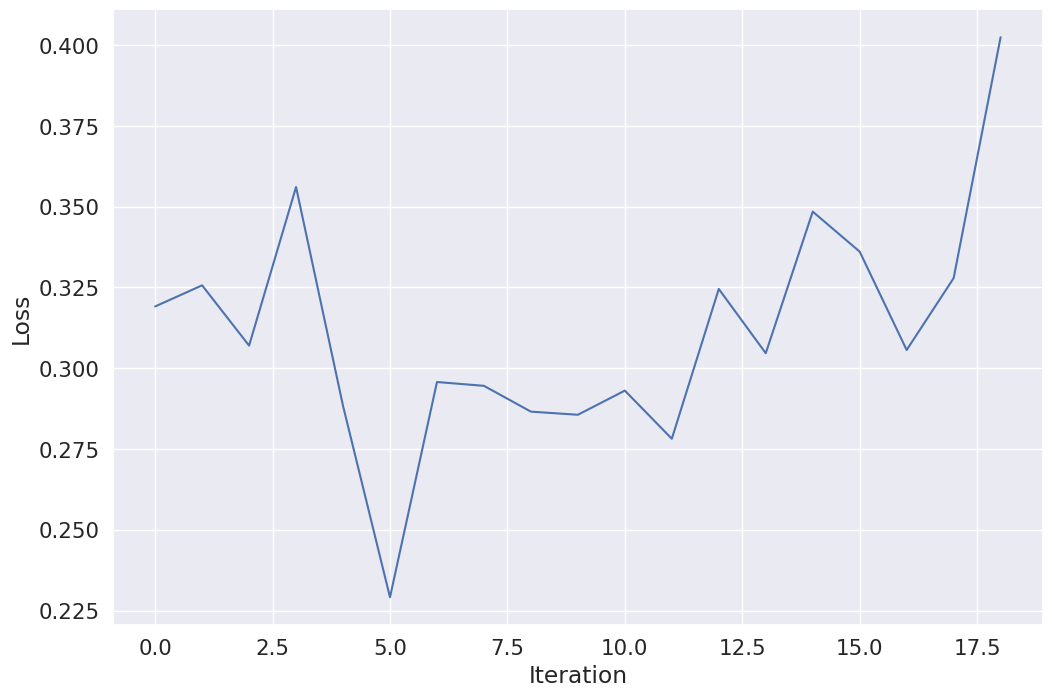

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

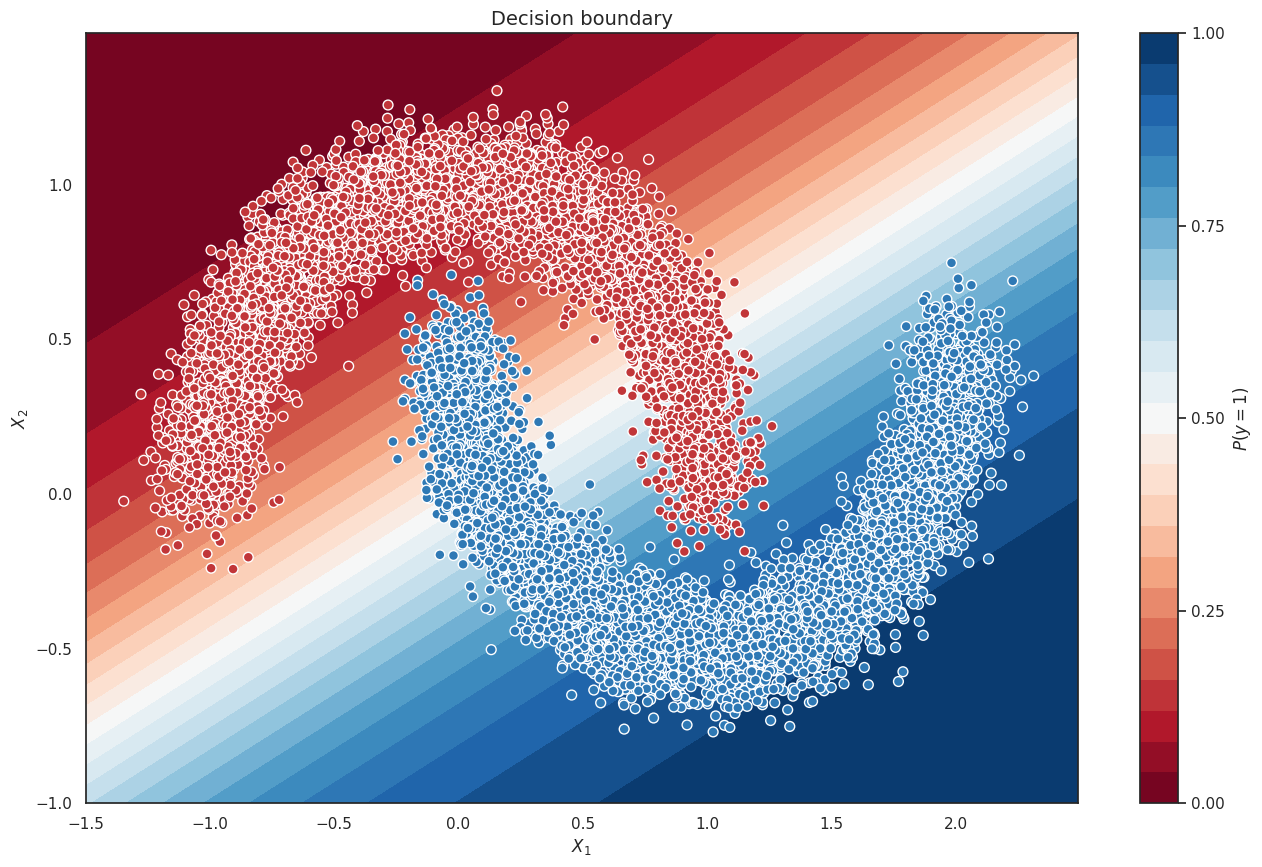

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score

# Создаем DataLoader для тестового набора
test_dataset = TensorDataset(X_train_t, y_train_t)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Теперь получаем предсказания на тестовых данных
test_predictions = predict(test_dataloader, linear_regression)

# Рассчитываем точность на тестовом наборе
# Преобразуем y_test_t в numpy перед сравнением (с использованием .numpy())
test_accuracy = accuracy_score(y_train_t.numpy(), test_predictions)  # y_test_t - истинные метки
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Test Accuracy: 85.69%


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 85.69%

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

# Создание DataLoader для тренировочного набора данных
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Создание DataLoader для тестового набора данных
valid_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

activation = nn.ELU
# Создание полносвязной нейронной сети
model = nn.Sequential(
    nn.Flatten(),                 # Уплощаем входной тензор (28x28) в вектор размерности 784
    nn.Linear(28 * 28, 128),      # Первый скрытый слой: 784 -> 128 нейронов
    nn.ELU(),                     # Активация для первого скрытого слоя
    nn.Linear(128, 128),          # Второй скрытый слой: 128 -> 128 нейронов
    nn.ELU(),                     # Активация для второго скрытого слоя
    nn.Linear(128, 10)            # Выходной слой: 128 -> 10 (для 10 классов)
)

In [ ]:
# Кросс-энтропийная функция потерь для многоклассовой классификации
criterion = nn.CrossEntropyLoss()

# Оптимизатор Adam
optimizer = torch.optim.Adam(model.parameters())

# Словарь с DataLoader-ами для тренировки и валидации
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Выбор устройства

# Перемещаем модель на выбранное устройство
model.to(device)

# Цикл обучения
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            # Перемещаем данные на выбранное устройство
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if k == "train":
                model.train()  # Переводим модель в режим тренировки
                optimizer.zero_grad()  # Обнуляем градиенты
                outp = model(x_batch)  # Получаем выходы модели
                loss = criterion(outp, y_batch)  # Считаем ошибку
                loss.backward()  # Обратный проход
                optimizer.step()  # Шаг оптимизации
            else:
                model.eval()  # Переводим модель в режим валидации
                with torch.no_grad():  # Отключаем градиенты
                    outp = model(x_batch)

            preds = outp.argmax(-1)  # Получаем предсказания
            correct = (preds == y_batch).sum()  # Считаем количество правильных предсказаний
            all = y_batch.size(0)  # Общее количество примеров

            epoch_correct += correct.item()  # Накопление правильных предсказаний
            epoch_all += all  # Накопление всех примеров

        # Вывод точности
        print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all:.4f}")
        accuracy[k].append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9794
Epoch: 1
Loader: valid. Accuracy: 0.9708
Epoch: 2
Loader: train. Accuracy: 0.9815
Epoch: 2
Loader: valid. Accuracy: 0.9741
Epoch: 3
Loader: train. Accuracy: 0.9834
Epoch: 3
Loader: valid. Accuracy: 0.9781
Epoch: 4
Loader: train. Accuracy: 0.9840
Epoch: 4
Loader: valid. Accuracy: 0.9709
Epoch: 5
Loader: train. Accuracy: 0.9867
Epoch: 5
Loader: valid. Accuracy: 0.9730
Epoch: 6
Loader: train. Accuracy: 0.9876
Epoch: 6
Loader: valid. Accuracy: 0.9763
Epoch: 7
Loader: train. Accuracy: 0.9900
Epoch: 7
Loader: valid. Accuracy: 0.9780
Epoch: 8
Loader: train. Accuracy: 0.9884
Epoch: 8
Loader: valid. Accuracy: 0.9790
Epoch: 9
Loader: train. Accuracy: 0.9905
Epoch: 9
Loader: valid. Accuracy: 0.9765
Epoch: 10
Loader: train. Accuracy: 0.9915
Epoch: 10
Loader: valid. Accuracy: 0.9792


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torch.utils.data import DataLoader

# Задаем трансформации и загружаем датасеты
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5,), (0.5,))
])

root = './'
train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Устройство
device = "cuda" if torch.cuda.is_available() else "cpu"

# Функция для создания модели с выбранной функцией активации
def create_model(activation_fn):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 128),
        activation_fn(),
        nn.Linear(128, 128),
        activation_fn(),
        nn.Linear(128, 10)
    )
    return model.to(device)

# Функция для тестирования активации
def test_activation_function(activation_fn):
    model = create_model(activation_fn)  # Создаем модель с выбранной активацией
    criterion = nn.CrossEntropyLoss()  # Функция потерь
    optimizer = optim.Adam(model.parameters())  # Оптимизатор

    accuracy = {"train": [], "valid": []}
    max_epochs = 10

    for epoch in range(max_epochs):
        for k, dataloader in {"train": train_dataloader, "valid": valid_dataloader}.items():
            epoch_correct = 0
            epoch_all = 0

            for x_batch, y_batch in dataloader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = y_batch.size(0)

                epoch_correct += correct.item()
                epoch_all += all

            accuracy[k].append(epoch_correct / epoch_all)

        print(f"Epoch {epoch + 1}/{max_epochs} completed")
        print(f"Train Accuracy: {accuracy['train'][-1]:.4f}, Valid Accuracy: {accuracy['valid'][-1]:.4f}")

    return accuracy["valid"]  # Возвращаем точность на валидации

# Тестирование разных активаций
elu_accuracy = test_activation_function(nn.ELU)  # ELU
relu_accuracy = test_activation_function(nn.ReLU)  # ReLU
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)  # LeakyReLU

# Выводим результаты
print("ELU Validation Accuracy:", elu_accuracy)
print("ReLU Validation Accuracy:", relu_accuracy)
print("LeakyReLU Validation Accuracy:", leaky_relu_accuracy)


Epoch 1/10 completed
Train Accuracy: 0.9041, Valid Accuracy: 0.9468
Epoch 2/10 completed
Train Accuracy: 0.9554, Valid Accuracy: 0.9593
Epoch 3/10 completed
Train Accuracy: 0.9669, Valid Accuracy: 0.9652
Epoch 4/10 completed
Train Accuracy: 0.9723, Valid Accuracy: 0.9634
Epoch 5/10 completed
Train Accuracy: 0.9776, Valid Accuracy: 0.9692
Epoch 6/10 completed
Train Accuracy: 0.9796, Valid Accuracy: 0.9725
Epoch 7/10 completed
Train Accuracy: 0.9822, Valid Accuracy: 0.9754
Epoch 8/10 completed
Train Accuracy: 0.9839, Valid Accuracy: 0.9736
Epoch 9/10 completed
Train Accuracy: 0.9851, Valid Accuracy: 0.9751
Epoch 10/10 completed
Train Accuracy: 0.9864, Valid Accuracy: 0.9759
Epoch 1/10 completed
Train Accuracy: 0.8877, Valid Accuracy: 0.9354
Epoch 2/10 completed
Train Accuracy: 0.9469, Valid Accuracy: 0.9531
Epoch 3/10 completed
Train Accuracy: 0.9611, Valid Accuracy: 0.9662
Epoch 4/10 completed
Train Accuracy: 0.9682, Valid Accuracy: 0.9634
Epoch 5/10 completed
Train Accuracy: 0.9715, Va

In [59]:
plain_accuracy = test_activation_function(nn.Identity)  # Идентичная активация (без изменений)
relu_accuracy = test_activation_function(nn.ReLU)  # Стандартная функция активации ReLU
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)  # Функция активации Leaky ReLU

Epoch 1/10 completed
Train Accuracy: 0.8754, Valid Accuracy: 0.9075
Epoch 2/10 completed
Train Accuracy: 0.8989, Valid Accuracy: 0.9163
Epoch 3/10 completed
Train Accuracy: 0.9031, Valid Accuracy: 0.9118
Epoch 4/10 completed
Train Accuracy: 0.9045, Valid Accuracy: 0.9071
Epoch 5/10 completed
Train Accuracy: 0.9092, Valid Accuracy: 0.8984
Epoch 6/10 completed
Train Accuracy: 0.9115, Valid Accuracy: 0.9162
Epoch 7/10 completed
Train Accuracy: 0.9109, Valid Accuracy: 0.9150
Epoch 8/10 completed
Train Accuracy: 0.9113, Valid Accuracy: 0.9200
Epoch 9/10 completed
Train Accuracy: 0.9141, Valid Accuracy: 0.9079
Epoch 10/10 completed
Train Accuracy: 0.9139, Valid Accuracy: 0.9181
Epoch 1/10 completed
Train Accuracy: 0.8870, Valid Accuracy: 0.9403
Epoch 2/10 completed
Train Accuracy: 0.9488, Valid Accuracy: 0.9588
Epoch 3/10 completed
Train Accuracy: 0.9620, Valid Accuracy: 0.9643
Epoch 4/10 completed
Train Accuracy: 0.9689, Valid Accuracy: 0.9681
Epoch 5/10 completed
Train Accuracy: 0.9738, Va

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

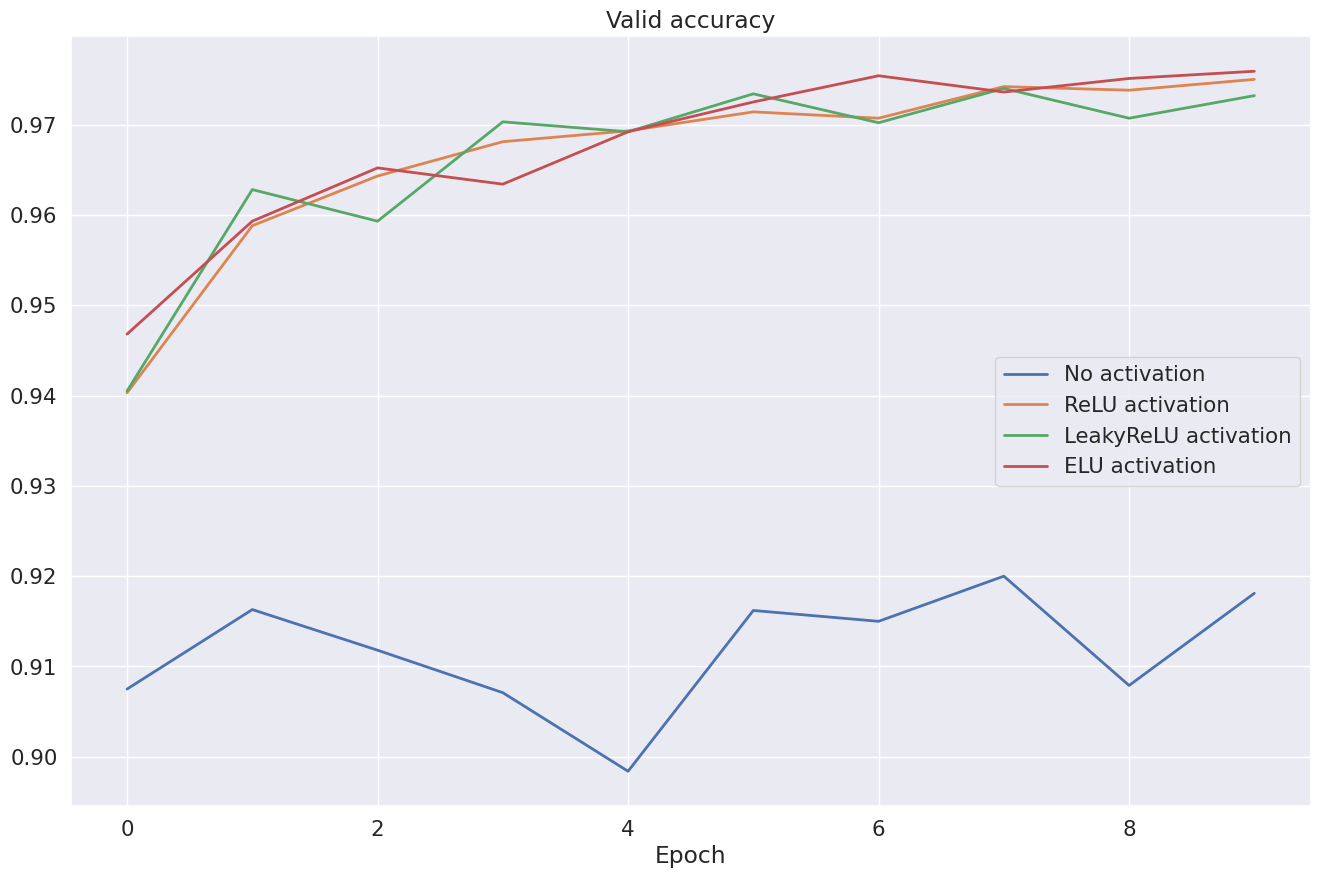

In [60]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

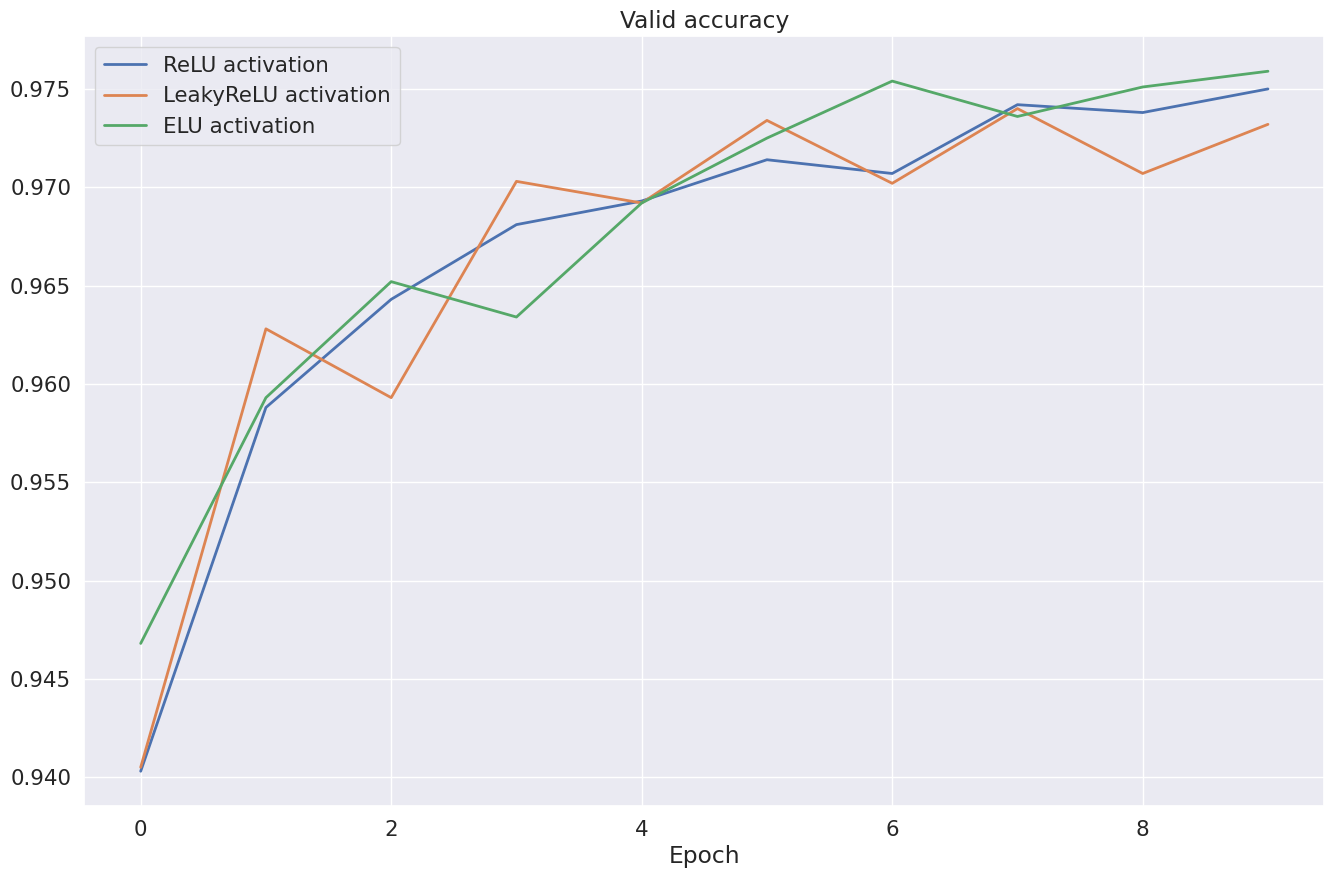

In [61]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ReLU показала наивысшую точность на валидации с результатом 0.9750 в последней эпохе.

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [62]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2024-11-16 17:51:03--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   209KB/s    in 0.2s    

2024-11-16 17:51:04 (209 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



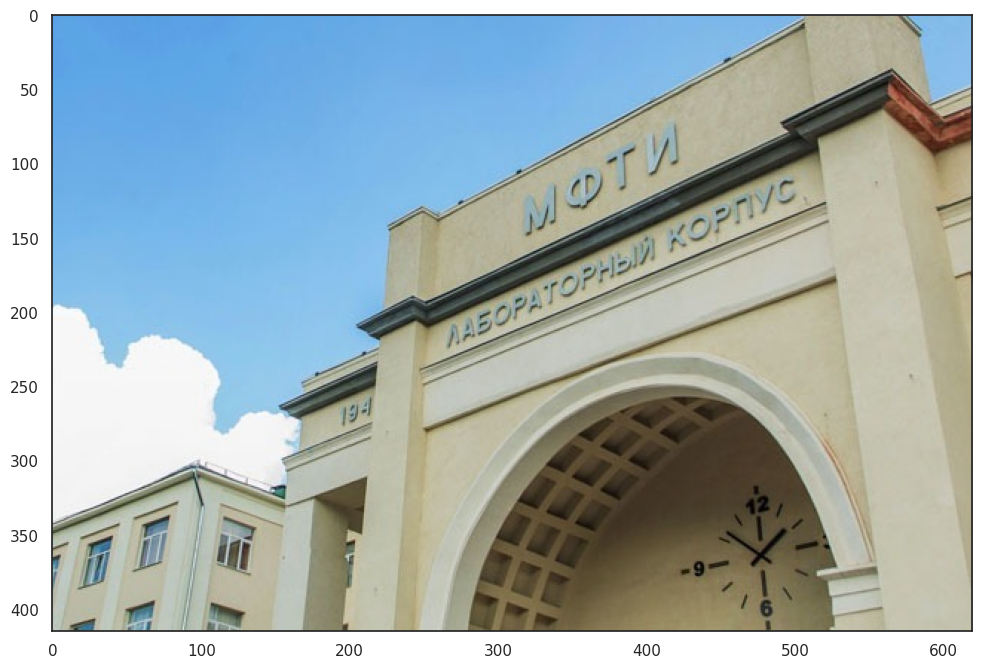

In [63]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [64]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

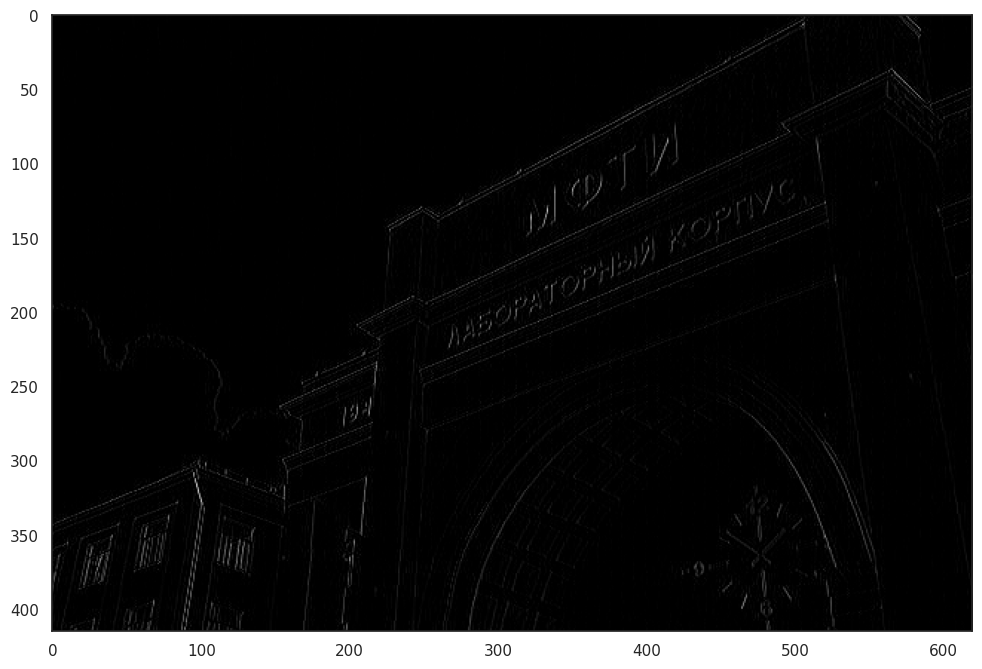

In [65]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 4) Выделение вертикальных границ.

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [66]:
import torch
import torch.nn as nn
import torch.optim as optim

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # Первый сверточный слой: 1 канал на входе, 6 выходных каналов, ядро 3x3
        self.conv1 = nn.Conv2d(1, 6, 3)

        # MaxPooling с ядром 2x2
        self.pool1 = nn.MaxPool2d(2, 2)

        # Второй сверточный слой: 6 каналов на входе, 16 каналов на выходе, ядро 3x3
        self.conv2 = nn.Conv2d(6, 16, 3)

        # MaxPooling с ядром 2x2
        self.pool2 = nn.MaxPool2d(2, 2)

        # Полносвязный слой с 120 нейронами
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Размеры после 2х пулинговых слоев (16 каналов и размер 5x5)

        # Полносвязный слой с 84 нейронами
        self.fc2 = nn.Linear(120, 84)

        # Выходной слой с 10 нейронами (для классификации 10 классов)
        self.fc3 = nn.Linear(84, 10)

        # Функции активации ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        # Применяем слои по очереди
        x = self.relu(self.conv1(x))  # Применяем свертку + активация
        x = self.pool1(x)  # Применяем MaxPooling

        x = self.relu(self.conv2(x))  # Применяем свертку + активация
        x = self.pool2(x)  # Применяем MaxPooling

        x = torch.flatten(x, 1)  # Уплощаем выход перед подачей на полносвязный слой

        x = self.relu(self.fc1(x))  # Применяем первый полносвязный слой + активация
        x = self.relu(self.fc2(x))  # Применяем второй полносвязный слой + активация

        x = self.fc3(x)  # Применяем выходной слой (нет активации, т.к. используется CrossEntropyLoss)

        return x

In [67]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as tfs
from torchvision.datasets import MNIST

# Задаем трансформации для изображений
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5,), (0.5,))
])

root = './'
train_dataset = MNIST(root, train=True, transform=data_tfs, download=True)
val_dataset = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Устройство
device = "cuda" if torch.cuda.is_available() else "cpu"

# Реализация LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Свёртка + ReLU
        x = self.pool1(x)  # MaxPooling

        x = self.relu(self.conv2(x))  # Свёртка + ReLU
        x = self.pool2(x)  # MaxPooling

        x = torch.flatten(x, 1)  # Уплощаем перед полносвязными слоями

        x = self.relu(self.fc1(x))  # Полносвязный слой + ReLU
        x = self.relu(self.fc2(x))  # Полносвязный слой + ReLU

        x = self.fc3(x)  # Выходной слой

        return x

# Инициализируем модель, критерий и оптимизатор
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Функция обучения модели
def train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=10):
    accuracy = {"train": [], "valid": []}

    for epoch in range(num_epochs):
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()  # Устанавливаем модель в режим тренировки
            else:
                model.eval()  # Устанавливаем модель в режим валидации

            epoch_correct = 0
            epoch_all = 0

            for inputs, labels in (train_dataloader if phase == "train" else valid_dataloader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Обнуляем градиенты

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)  # Получаем выходы от модели
                    loss = criterion(outputs, labels)  # Вычисляем ошибку

                    if phase == "train":
                        loss.backward()  # Обратное распространение ошибки
                        optimizer.step()  # Обновление весов

                _, preds = torch.max(outputs, 1)  # Получаем прогнозы
                epoch_correct += (preds == labels).sum().item()  # Считаем количество правильных предсказаний
                epoch_all += labels.size(0)  # Считаем общее количество примеров

            accuracy[phase].append(epoch_correct / epoch_all)  # Сохраняем точность

        # Выводим точность после каждого эпока
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Accuracy: {accuracy['train'][-1]:.4f}, "
              f"Valid Accuracy: {accuracy['valid'][-1]:.4f}")

    return accuracy

# Обучаем модель
accuracy = train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs=10)


Epoch 1/10, Train Accuracy: 0.9133, Valid Accuracy: 0.9777
Epoch 2/10, Train Accuracy: 0.9761, Valid Accuracy: 0.9792
Epoch 3/10, Train Accuracy: 0.9832, Valid Accuracy: 0.9868
Epoch 4/10, Train Accuracy: 0.9872, Valid Accuracy: 0.9873
Epoch 5/10, Train Accuracy: 0.9891, Valid Accuracy: 0.9857
Epoch 6/10, Train Accuracy: 0.9907, Valid Accuracy: 0.9889
Epoch 7/10, Train Accuracy: 0.9924, Valid Accuracy: 0.9879
Epoch 8/10, Train Accuracy: 0.9932, Valid Accuracy: 0.9888
Epoch 9/10, Train Accuracy: 0.9938, Valid Accuracy: 0.9868
Epoch 10/10, Train Accuracy: 0.9953, Valid Accuracy: 0.9891


In [69]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

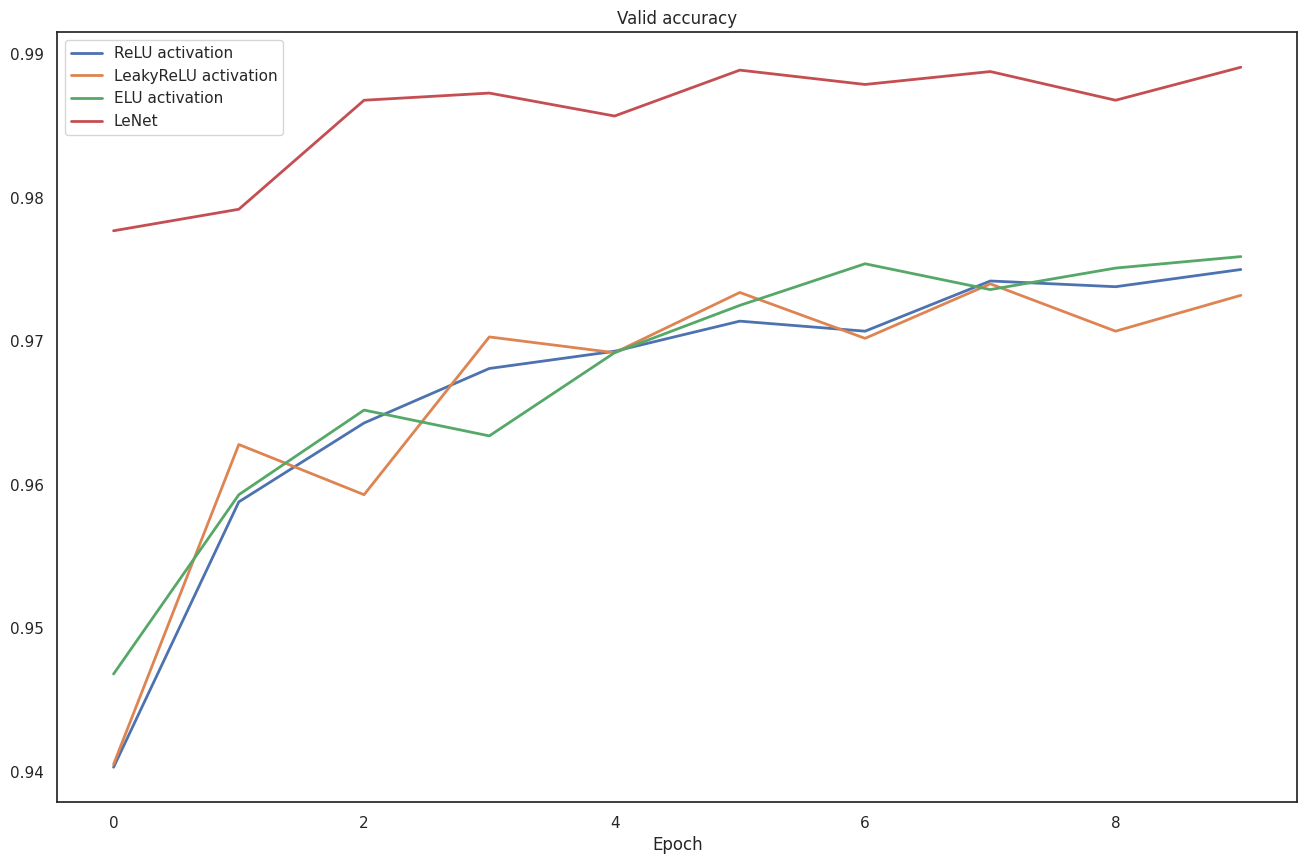

In [70]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99